In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests as req
import os
import gmaps
from citipy import citipy
from datetime import datetime
from config import weather_api_key
from config import g_key
from scipy.stats import linregress

In [2]:
def build_url(city):
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    return base_url + "units=Imperial" + "&APPID=" + weather_api_key + "&q=" + city

In [3]:
url = "http://api.openweathermap.org/data/2.5/weather?" + "units=Imperial" + "&APPID=" + weather_api_key

In [4]:
cities = ["Pittsburgh", "Austin", "New  York", "Los Angeles", "Seattle"]
for city in cities:
    try:
        city_url = url + "&q=" + city
        weather = req.get(city_url).json()
        temp = weather['main']['temp']
    except KeyError:
        print("KeyError received for " + city)
        continue
    print("It is currently " + str(temp) + " degrees in " + city)

        

It is currently 69.06 degrees in Pittsburgh
It is currently 87.89 degrees in Austin
KeyError received for New  York
It is currently 72.5 degrees in Los Angeles
It is currently 47.53 degrees in Seattle


# Create zipped lat_lngs[] with 1500 random lat & lon values

In [5]:
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)
lat_lngs

# create coordinates[] from zipped lat_lngs[]

In [6]:
coordinates = list(lat_lngs)

# Use citipy to find nearest_city for coordinates[] and append to cities[]

In [7]:
cities = []
for coordinate in coordinates:
    x = coordinate[0]
    y = coordinate[1]
    city_name    = citipy.nearest_city(coordinate[0], coordinate[1]).city_name
    country_code = citipy.nearest_city(coordinate[0], coordinate[1]).country_code
    #print(f"{x} {y} {city_name} {country_code}")
    if city_name not in cities:
        cities.append(city_name)
print(len(cities))

634


# Append rows to city_data[] for each city

In [8]:
city_data = []
def get_cities_from_weatherfoo():

    print("Beginning Data Retrieval     ")
    print("-----------------------------")
    record_count = 1
    set_count = 1
    
    for i, city in enumerate(cities):

        # Group cities in sets of 50 for logging purposes.
        if (i % 50 == 0 and i >= 50):
            set_count += 1
            record_count = 1
        # Create endpoint URL with each city.
        city_url = url + "&q=" + city.replace(" ","+")
        #print(city_url)

        # Log the URL, record, and set numbers and the city.
        print(f"Processing Record {record_count} of Set {set_count} | {city}")
        # Add 1 to the record count.
        record_count += 1
    
        # Run an API request for each of the cities.
        try:
            # Parse the JSON and retrieve data.
            city_weather = req.get(city_url).json()
            # Parse out the needed data.
            city_lat = city_weather["coord"]["lat"]
            city_lng = city_weather["coord"]["lon"]
            city_max_temp = city_weather["main"]["temp_max"]
            city_humidity = city_weather["main"]["humidity"]
            city_clouds = city_weather["clouds"]["all"]
            city_wind = city_weather["wind"]["speed"]
            city_country = city_weather["sys"]["country"]
            # Convert the date to ISO standard.
            city_date = datetime.utcfromtimestamp(city_weather["dt"]).strftime('%Y-%m-%d %H:%M:%S')
            # Append the city information into city_data list.
            city_data.append({"City": city.title(),
                          "Lat": city_lat,
                          "Lng": city_lng,
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

            #print("city="+city
            #      +", lat="+str(city_weather['coord']['lat'])
            #      +", lon="+str(city_weather['coord']['lon']))  

        # If an error is experienced, skip the city.
        except:
            print("City not found. Skipping...")
            pass

    print("-----------------------------")
    print("Data Retrieval Complete      ")
    print("-----------------------------")

# Create city_data_df DataFrame

In [9]:
if os.path.isfile("weather_data/cities.csv"):
    city_data_df = pd.read_csv("weather_data/cities.csv")
else:
    get_cities_from_weatherfoo()
    city_data_df = pd.DataFrame(city_data)
    
city_data_df.head(10)

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | castro
Processing Record 2 of Set 1 | bluff
Processing Record 3 of Set 1 | ushuaia
Processing Record 4 of Set 1 | sydney
Processing Record 5 of Set 1 | bambous virieux
Processing Record 6 of Set 1 | mataura
Processing Record 7 of Set 1 | rikitea
Processing Record 8 of Set 1 | vostok
Processing Record 9 of Set 1 | puerto ayora
Processing Record 10 of Set 1 | carnarvon
Processing Record 11 of Set 1 | jamestown
Processing Record 12 of Set 1 | chagda
City not found. Skipping...
Processing Record 13 of Set 1 | port elizabeth
Processing Record 14 of Set 1 | thompson
Processing Record 15 of Set 1 | chapeco
Processing Record 16 of Set 1 | naze
Processing Record 17 of Set 1 | vaini
Processing Record 18 of Set 1 | taolanaro
City not found. Skipping...
Processing Record 19 of Set 1 | illoqqortoormiut
City not found. Skipping...
Processing Record 20 of Set 1 | mahebourg
Processing Record 21 of Set 1 | barrow

Processing Record 41 of Set 4 | kompaniyivka
Processing Record 42 of Set 4 | pathein
Processing Record 43 of Set 4 | poum
Processing Record 44 of Set 4 | soyo
Processing Record 45 of Set 4 | gimbi
Processing Record 46 of Set 4 | kavieng
Processing Record 47 of Set 4 | minna
Processing Record 48 of Set 4 | provideniya
Processing Record 49 of Set 4 | lodja
Processing Record 50 of Set 4 | campbell river
Processing Record 1 of Set 5 | scarborough
Processing Record 2 of Set 5 | bathsheba
Processing Record 3 of Set 5 | raudeberg
Processing Record 4 of Set 5 | tuatapere
Processing Record 5 of Set 5 | mar del plata
Processing Record 6 of Set 5 | bilibino
Processing Record 7 of Set 5 | sakakah
Processing Record 8 of Set 5 | dhidhdhoo
Processing Record 9 of Set 5 | yantongshan
Processing Record 10 of Set 5 | vila velha
Processing Record 11 of Set 5 | santa rosa del sur
Processing Record 12 of Set 5 | hirna
Processing Record 13 of Set 5 | kushmurun
Processing Record 14 of Set 5 | lewistown
Proces

Processing Record 36 of Set 8 | chara
Processing Record 37 of Set 8 | grand river south east
City not found. Skipping...
Processing Record 38 of Set 8 | kudat
Processing Record 39 of Set 8 | teguise
Processing Record 40 of Set 8 | malayal
Processing Record 41 of Set 8 | yumen
Processing Record 42 of Set 8 | carutapera
Processing Record 43 of Set 8 | bytow
Processing Record 44 of Set 8 | port lincoln
Processing Record 45 of Set 8 | puerto escondido
Processing Record 46 of Set 8 | carbonia
Processing Record 47 of Set 8 | ahipara
Processing Record 48 of Set 8 | broome
Processing Record 49 of Set 8 | emerald
Processing Record 50 of Set 8 | lagos
Processing Record 1 of Set 9 | ojinaga
Processing Record 2 of Set 9 | bridlington
Processing Record 3 of Set 9 | lompoc
Processing Record 4 of Set 9 | damietta
Processing Record 5 of Set 9 | souillac
Processing Record 6 of Set 9 | tabou
Processing Record 7 of Set 9 | kingaroy
Processing Record 8 of Set 9 | ouesso
Processing Record 9 of Set 9 | ustr

Processing Record 22 of Set 12 | byron bay
Processing Record 23 of Set 12 | masjed-e soleyman
City not found. Skipping...
Processing Record 24 of Set 12 | findochty
Processing Record 25 of Set 12 | pullman
Processing Record 26 of Set 12 | krasnovishersk
Processing Record 27 of Set 12 | mae ramat
Processing Record 28 of Set 12 | ayan
Processing Record 29 of Set 12 | san jeronimo
Processing Record 30 of Set 12 | kiunga
Processing Record 31 of Set 12 | jalingo
Processing Record 32 of Set 12 | noumea
Processing Record 33 of Set 12 | cockburn town
Processing Record 34 of Set 12 | russell
Processing Record 35 of Set 12 | intregalde
City not found. Skipping...
Processing Record 36 of Set 12 | south venice
Processing Record 37 of Set 12 | manacapuru
Processing Record 38 of Set 12 | kualakapuas
Processing Record 39 of Set 12 | saryozek
Processing Record 40 of Set 12 | rincon
Processing Record 41 of Set 12 | salmas
Processing Record 42 of Set 12 | dafeng
Processing Record 43 of Set 12 | necochea

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Castro,-24.7911,-50.0119,67.12,67,67,2.10,BR,2021-04-09 23:56:20
1,Bluff,-46.6000,168.3333,57.00,80,98,1.99,NZ,2021-04-09 23:56:19
2,Ushuaia,-54.8000,-68.3000,46.40,66,40,6.91,AR,2021-04-09 23:56:05
3,Sydney,-33.8679,151.2073,68.00,48,40,19.57,AU,2021-04-10 00:00:26
4,Bambous Virieux,-20.3428,57.7575,79.00,94,75,3.44,MU,2021-04-09 23:56:59
5,Mataura,-46.1927,168.8643,57.00,80,100,1.99,NZ,2021-04-09 23:56:34
6,Rikitea,-23.1203,-134.9692,77.90,74,48,9.01,PF,2021-04-09 23:56:19
7,Vostok,46.4856,135.8833,37.38,52,66,4.94,RU,2021-04-10 00:00:34
8,Puerto Ayora,-0.7393,-90.3518,77.00,95,93,7.00,EC,2021-04-09 23:56:48
9,Carnarvon,-24.8667,113.6333,78.80,73,75,8.05,AU,2021-04-09 23:56:05


In [10]:
new_column_order = ["City", "Country", "Date", "Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed"]
city_data_df = city_data_df[new_column_order]
city_data_df.head()

,City,Country,Date,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed
0,Castro,BR,2021-04-09 23:56:20,-24.7911,-50.0119,67.12,67,67,2.10
1,Bluff,NZ,2021-04-09 23:56:19,-46.6000,168.3333,57.00,80,98,1.99
2,Ushuaia,AR,2021-04-09 23:56:05,-54.8000,-68.3000,46.40,66,40,6.91
3,Sydney,AU,2021-04-10 00:00:26,-33.8679,151.2073,68.00,48,40,19.57
4,Bambous Virieux,MU,2021-04-09 23:56:59,-20.3428,57.7575,79.00,94,75,3.44


# Output cities.csv

In [11]:
# Create the output file (CSV).
output_data_file = "weather_data/cities.csv"
# Export the City_Data into a CSV.
city_data_df.to_csv(output_data_file, index_label="City_ID")

# Get parameters for scatter plots from city_data_df

In [12]:
lats = city_data_df["Lat"]
max_temps = city_data_df["Max Temp"]
humidity = city_data_df["Humidity"]
cloudiness = city_data_df["Cloudiness"]
wind_speed = city_data_df["Wind Speed"]

# Latitude vs. Max Temp scatter plot

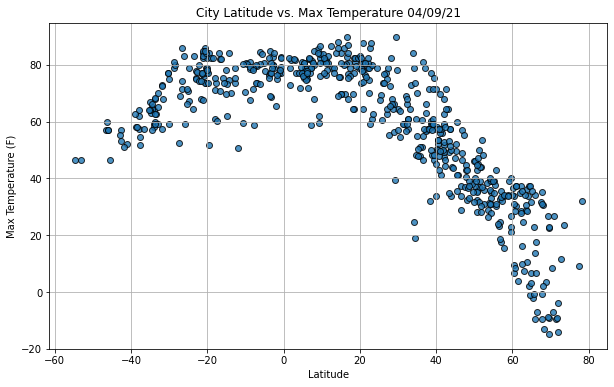

In [13]:
# Import time module
import time

# Build the scatter plot for latitude vs. max temperature.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            max_temps,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Max Temperature "+ time.strftime("%x"))
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure.
plt.savefig("weather_data/Fig1.png")

# Show plot.
plt.show()

# Latitude vs. Humidity scatter plot

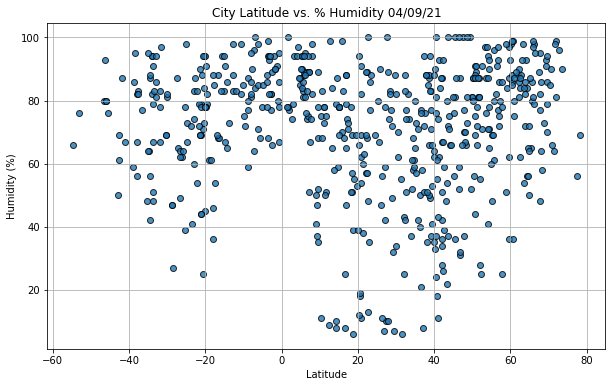

In [14]:
# Build the scatter plots for latitude vs. humidity.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            humidity,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. % Humidity "+ time.strftime("%x"))
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig2.png")
# Show plot.
plt.show()

# Latitude vs. Cloudiness scatter plot

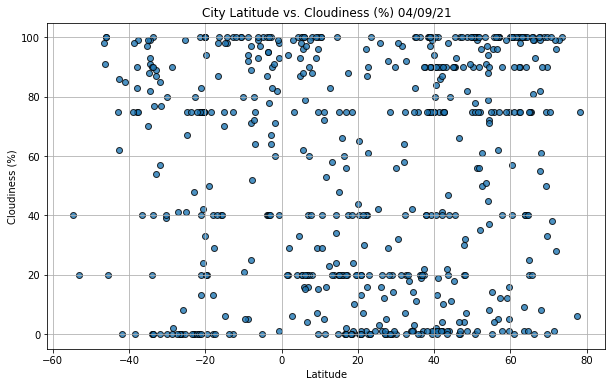

In [15]:
# Build the scatter plots for latitude vs. cloudiness.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            cloudiness,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Cloudiness (%) "+ time.strftime("%x"))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig3.png")
# Show plot.
plt.show()

# Latitude vs. Wind Speed scatter plot

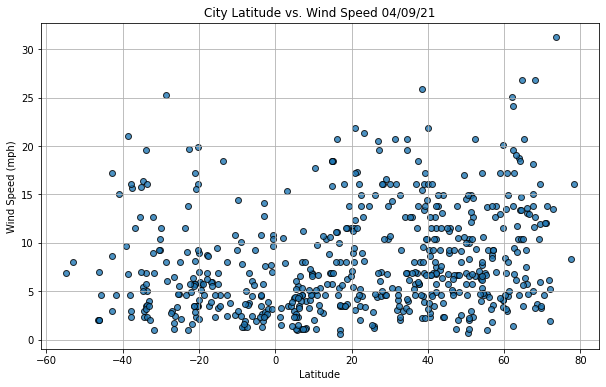

In [16]:
# Build the scatter plots for latitude vs. wind speed.
plt.subplots(figsize=(10, 6))
plt.scatter(lats,
            wind_speed,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Wind Speed "+ time.strftime("%x"))
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig4.png")
# Show plot.
plt.show()

In [17]:
# Create a function to create perform linear regression on the weather data
# and plot a regression line and the equation with the data.
def plot_linear_regression(x_values, y_values, title, y_label, text_coordinates, figpath=None):
    # Run regression on hemisphere weather data.
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
    print("slope=" + str(slope))
    print("intercept=" + str(intercept))
    print("r_value=" + str(r_value))
    print("p_value=" + str(p_value))
    print("std_err=" + str(std_err))
    
    # Calculate the regression line "y values" from the slope and intercept.
    regress_values = x_values * slope + intercept
    # Get the equation of the line.
    #line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) + " r=" + str(round(r_value,2)) + " p=" + str(round(p_value,2)) + " stderr=" + str(round(std_err,2))
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Create a scatter plot and plot the regression line.
    plt.subplots(figsize=(10, 6))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r")
    # Annotate the text for the line equation.
    plt.annotate(line_eq, text_coordinates, fontsize=15, color="red")
    plt.title(title)
    plt.xlabel('Latitude')
    plt.ylabel(y_label)
    plt.savefig(figpath)
    plt.show()

In [18]:
index13 = city_data_df.loc[13]
index13

City                      Chapeco
Country                        BR
Date          2021-04-10 00:00:36
Lat                      -27.0964
Lng                      -52.6183
Max Temp                    69.01
Humidity                       65
Cloudiness                     41
Wind Speed                   2.93
Name: 13, dtype: object

# Create northern_hemi_df and souther_hemi_df

In [19]:
northern_hemi_df = city_data_df.loc[(city_data_df["Lat"] >= 0)]
southern_hemi_df = city_data_df.loc[(city_data_df["Lat"] < 0)]

# Linear regression on Northern Max Temp

slope=-1.1047678765315163
intercept=94.26203615331067
r_value=-0.8910279345704566
p_value=4.4028412040463386e-144
std_err=0.027662161388796333


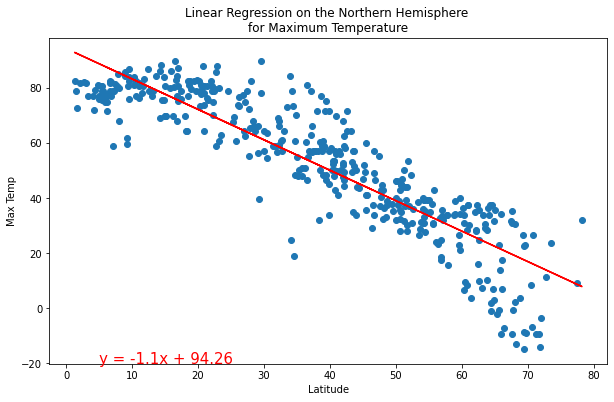

In [20]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Max Temp"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor Maximum Temperature',
                       'Max Temp',
                       (5,-20),
                       "weather_data/temp_vs_lat_north.png")

# Linear regression on Southern Max Temp

slope=0.5049038069871025
intercept=82.12169728243052
r_value=0.65956538566568
p_value=1.36924914966846e-22
std_err=0.04439255981483376


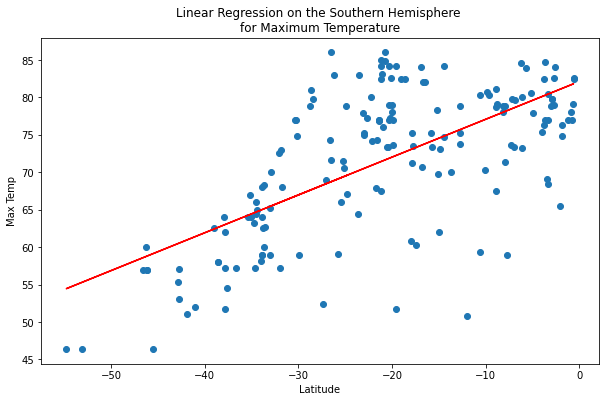

In [21]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Max Temp"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor Maximum Temperature',
                       'Max Temp',
                       (-55,90),
                       "weather_data/temp_vs_lat_south.png")

# Linear regression on Northern Humidity

slope=0.17120517786427156
intercept=62.74424802918121
r_value=0.14926069069731882
p_value=0.0022710414096734953
std_err=0.0557415195868421


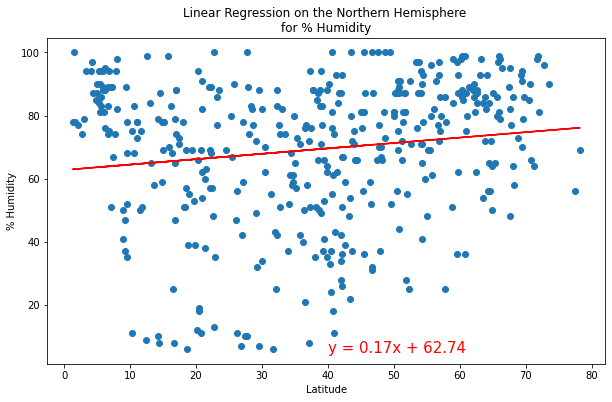

In [22]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Humidity"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor % Humidity',
                       '% Humidity',
                       (40,5),
                       "weather_data/hum_vs_lat_north.png")

# Linear regression on Southern Humidity

slope=0.30838513851937427
intercept=82.63946156458682
r_value=0.255237513038273
p_value=0.0007818232234658893
std_err=0.09012933092583802


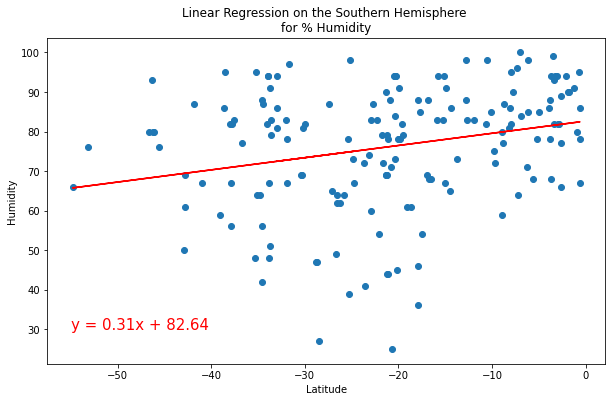

In [23]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Humidity"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor % Humidity',
                       'Humidity',
                       (-55, 30),
                      "weather_data/hum_vs_lat_south.png")

# Linear regression on Northern Cloudiness

slope=0.4642444272807908
intercept=34.73064665249906
r_value=0.23888077390842014
p_value=8.260456971823614e-07
std_err=0.09274840166566317


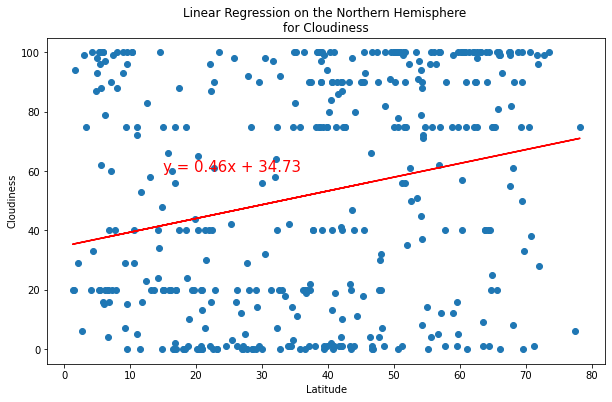

In [24]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Cloudiness"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor Cloudiness',
                       'Cloudiness',
                       (15,60),
                      "weather_data/clouds_vs_lat_north.png")

# Linear regression on Southern Cloudiness

slope=0.30470347428681
intercept=65.47987980597838
r_value=0.10715292311151661
p_value=0.1642851522915487
std_err=0.21812783474804842


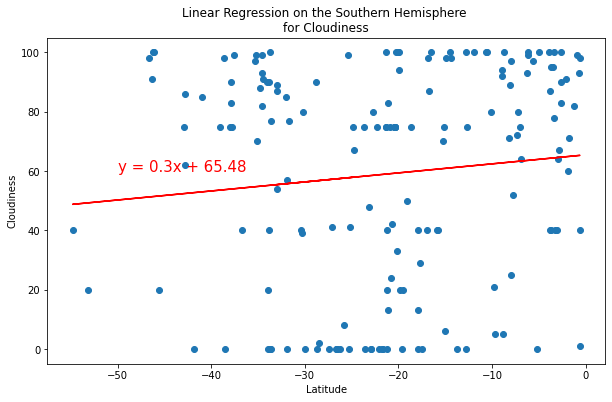

In [25]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Cloudiness"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor Cloudiness',
                       'Cloudiness',
                       (-50,60),
                      "weather_data/clouds_vs_lat_south.png")

# Linear regression on Northern Wind Speed

slope=0.06692857078176086
intercept=6.040875788693779
r_value=0.2429383940905585
p_value=5.291962114729848e-07
std_err=0.013134260833738746


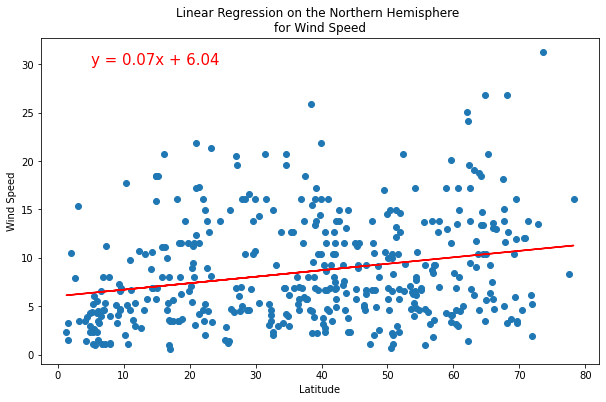

In [26]:
# Linear regression on the Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Wind Speed"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Northern Hemisphere \nfor Wind Speed',
                       'Wind Speed',
                       (5, 30),
                       "weather_data/wind_vs_lat_north.png")

# Linear regression on Southern Wind Speed

slope=-0.06464860695593513
intercept=5.235832865541389
r_value=-0.1753575770773827
p_value=0.022180248004076187
std_err=0.028002566436047135


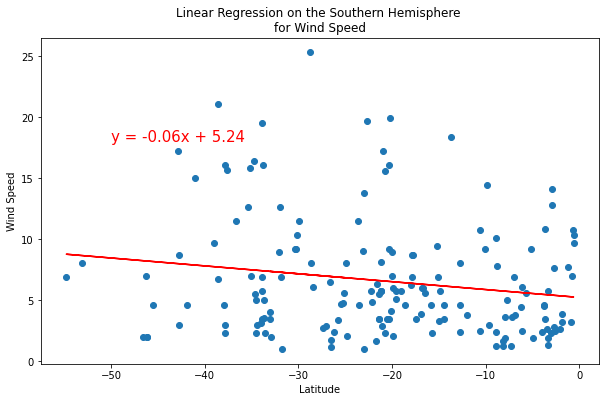

In [27]:
# Linear regression on the Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Wind Speed"]
# Call the function.
plot_linear_regression(x_values, 
                       y_values,
                       'Linear Regression on the Southern Hemisphere \nfor Wind Speed',
                       'Wind Speed',
                       (-50,18),
                      "weather_data/wind_vs_lat_south.png")